In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import matplotlib.patches as mpatches
import leidenalg
import igraph as ig

In [2]:
data_path = '/Users/charlesxu/local/data/mcp/flywire/ring_extend/'
results_path = os.path.join(data_path, 'results')
save_data = True
if save_data:
    os.makedirs(results_path, exist_ok=True)

## Preprocessing

Signed matrix shape: (855, 855)


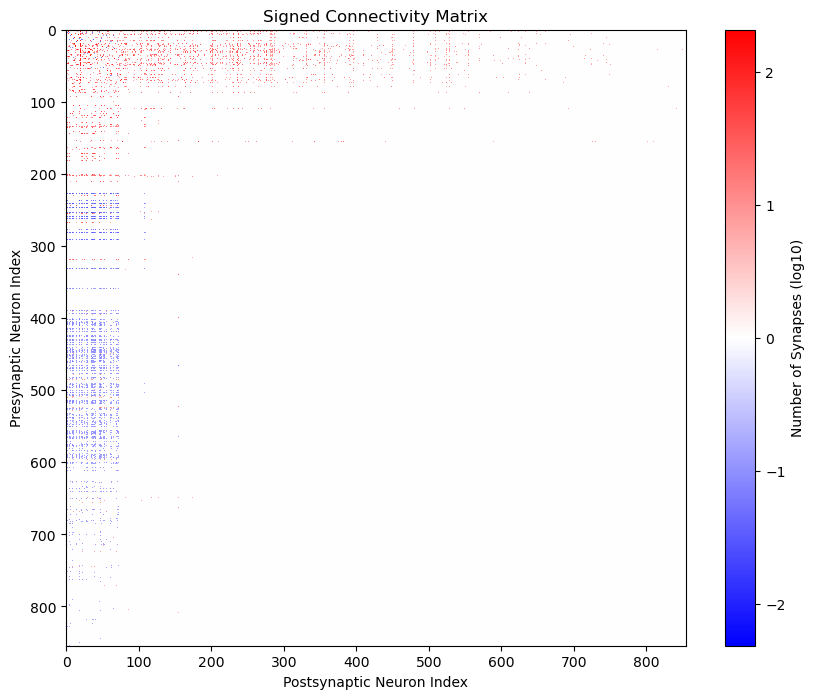

In [3]:
# Read the CSV file
connectivity_matrix_signed_df = pd.read_csv(os.path.join(data_path, 'connectivity_matrix_signed.csv'))

# Convert to square matrix (assuming first column might be row labels)
if connectivity_matrix_signed_df.shape[1] == connectivity_matrix_signed_df.shape[0] + 1:
    # If there's an extra column (likely row labels), drop it
    C_signed = connectivity_matrix_signed_df.iloc[:, 1:].values
else:
    # Otherwise, use all columns
    C_signed = connectivity_matrix_signed_df.values

print(f"Signed matrix shape: {C_signed.shape}")

# Visualize the signed connectivity matrix
plt.figure(figsize=(10, 8))
plt.imshow(np.log10(np.abs(C_signed) + 1) * np.sign(C_signed), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(C_signed) + 1)), 
           vmax=np.max(np.log10(np.abs(C_signed) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Signed Connectivity Matrix')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')
plt.show()

In [4]:
# Read the ctoi CSV file
ctoi_df = pd.read_csv(os.path.join(data_path, 'ctoi_list.csv'))
ctoi_list = ctoi_df['Cell Type'].tolist()
print(f"Cell type list length: {len(ctoi_list)}")
print(f"First 10 cell types: {ctoi_list[:10]}")

# Read the noi CSV file
noi_df = pd.read_csv(os.path.join(data_path, 'noi_list.csv'))
noi_list = noi_df['Neuron ID'].tolist()
print(f"Neuron ID list length: {len(noi_list)}")
print(f"First 10 neuron IDs: {noi_list[:10]}")

Cell type list length: 855
First 10 cell types: ['EPG', 'EL', 'EPG', 'EL', 'EPG', 'EL', 'EPG', 'EL', 'EPG', 'ExR6']
Neuron ID list length: 855
First 10 neuron IDs: [720575940631125036, 720575940611964882, 720575940626137895, 720575940629459441, 720575940604801993, 720575940629902206, 720575940608722371, 720575940631848791, 720575940628843458, 720575940620027515]


### Group by cell type

In [5]:
## Group by cell type and then for noi and connectivity matrix
# Create a mapping from cell type to indices
cell_type_indices = {}
for i, cell_type in enumerate(ctoi_list):
    if cell_type not in cell_type_indices:
        cell_type_indices[cell_type] = []
    cell_type_indices[cell_type].append(i)

# Get unique cell types in order of first appearance
unique_cell_types = []
seen_types = set()
for cell_type in ctoi_list:
    if cell_type not in seen_types:
        unique_cell_types.append(cell_type)
        seen_types.add(cell_type)

# Sort unique cell types alphabetically
unique_cell_types_sorted = sorted(unique_cell_types)

print(f"Sorted unique cell types: {unique_cell_types_sorted}")
print(f"Number of unique cell types: {len(unique_cell_types_sorted)}")

# Create new ordering with alphabetically sorted cell types
new_order_sorted = []
ctoi_grouped_sorted = []
noi_grouped_sorted = []

for cell_type in unique_cell_types_sorted:
    indices = cell_type_indices[cell_type]
    new_order_sorted.extend(indices)
    # Add cell types for this group
    ctoi_grouped_sorted.extend([cell_type] * len(indices))
    # Add corresponding neuron IDs
    for idx in indices:
        noi_grouped_sorted.append(noi_list[idx])

print(f"Sorted new order length: {len(new_order_sorted)}")
print(f"Sorted grouped ctoi length: {len(ctoi_grouped_sorted)}")
print(f"Sorted grouped noi length: {len(noi_grouped_sorted)}")

# Reorder the connectivity matrix with alphabetically sorted groups
C_signed_grouped_sorted = C_signed[np.ix_(new_order_sorted, new_order_sorted)]

print(f"Sorted grouped matrix shape: {C_signed_grouped_sorted.shape}")

# Update the variables to use the sorted versions
ctoi_grouped = ctoi_grouped_sorted
noi_grouped = noi_grouped_sorted
C_signed_grouped = C_signed_grouped_sorted
new_order = new_order_sorted
unique_cell_types = unique_cell_types_sorted

# Get the number of cells in each cell type
cell_type_counts = {}
for cell_type in unique_cell_types:
    cell_type_counts[cell_type] = len(cell_type_indices[cell_type])

print("Number of cells in each cell type:")
for cell_type in unique_cell_types:
    print(f"{cell_type}: {cell_type_counts[cell_type]}")

print(f"\nTotal number of cell types: {len(unique_cell_types)}")
print(f"Total number of cells: {sum(cell_type_counts.values())}")

Sorted unique cell types: ['CB.FB2I3', 'CB.FB3', 'CB0698', 'Delta7', 'EL', 'EPG', 'EPGt', 'ER1', 'ER2', 'ER3a', 'ER3d', 'ER3m', 'ER3p', 'ER3w', 'ER4d', 'ER4m', 'ER5', 'ER6', 'ExR1', 'ExR2', 'ExR3', 'ExR4', 'ExR5', 'ExR6', 'ExR7', 'ExR8', 'FB1G', 'FB4A', 'FB4Y', 'FB5V', 'FB5Z', 'FC2C', 'FS2', 'FS4A', 'GLNO', 'IbSpsP', 'LAL117', 'LAL121', 'LAL123', 'LAL184', 'LAL190', 'LHPV6q1', 'LPsP', 'M_lPNm12', 'OCG08', 'P1-9', 'P6-8P9', 'PEG', 'PEN_a(PEN1)', 'PEN_b(PEN2)', 'PFGs', 'PFL1', 'PFL2', 'PFL3', 'PFNa', 'PFNd', 'PFNm', 'PFNv', 'PFR', 'SIFa', 'WED160', 'cM11', 'hDeltaA', 'hDeltaB', 'hDeltaG', 'hDeltaI', 'hb-1934975261', 'hb-5813069570']
Number of unique cell types: 68
Sorted new order length: 855
Sorted grouped ctoi length: 855
Sorted grouped noi length: 855
Sorted grouped matrix shape: (855, 855)
Number of cells in each cell type:
CB.FB2I3: 2
CB.FB3: 3
CB0698: 1
Delta7: 40
EL: 17
EPG: 47
EPGt: 4
ER1: 29
ER2: 41
ER3a: 1
ER3d: 42
ER3m: 15
ER3p: 17
ER3w: 25
ER4d: 26
ER4m: 11
ER5: 17
ER6: 4
ExR

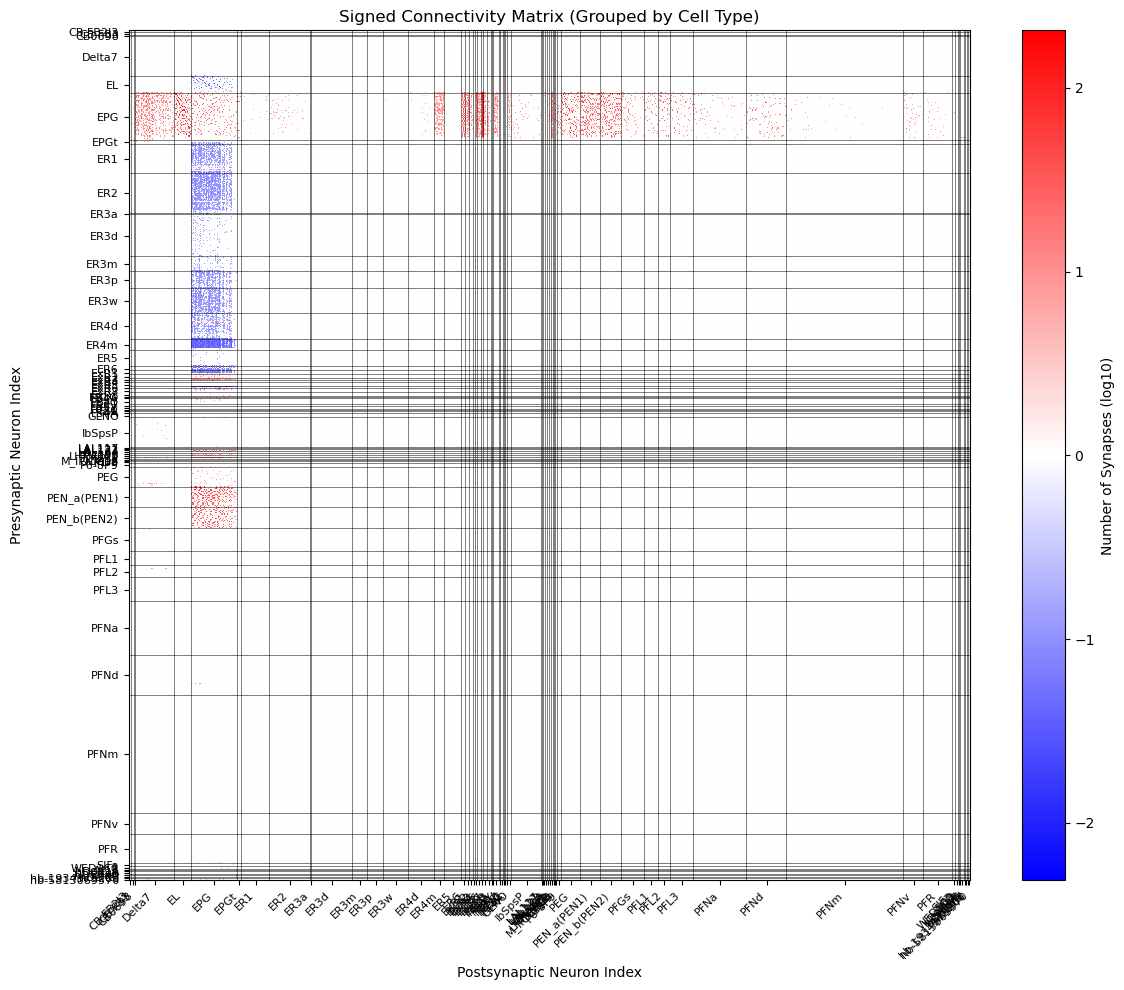

In [6]:
# Visualize the grouped connectivity matrix with cell type labels
plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(C_signed_grouped) + 1) * np.sign(C_signed_grouped), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(C_signed_grouped) + 1)), 
           vmax=np.max(np.log10(np.abs(C_signed_grouped) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Signed Connectivity Matrix (Grouped by Cell Type)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add cell type group boundaries and labels
group_boundaries = []
tick_positions = []
tick_labels = []
current_pos = 0
for cell_type in unique_cell_types:
    group_size = len(cell_type_indices[cell_type])
    group_boundaries.append(current_pos + group_size)

    # Add group label at the center of each group
    center_pos = current_pos + group_size / 2
    tick_positions.append(center_pos)
    tick_labels.append(cell_type)

    # Set x and y ticks with cell type labels
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=8)
    plt.yticks(tick_positions, tick_labels, fontsize=8)
    current_pos += group_size

# Add vertical and horizontal lines to separate groups
for boundary in group_boundaries[:-1]:  # Exclude the last boundary
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

### Weight-only (unsigned) matrix

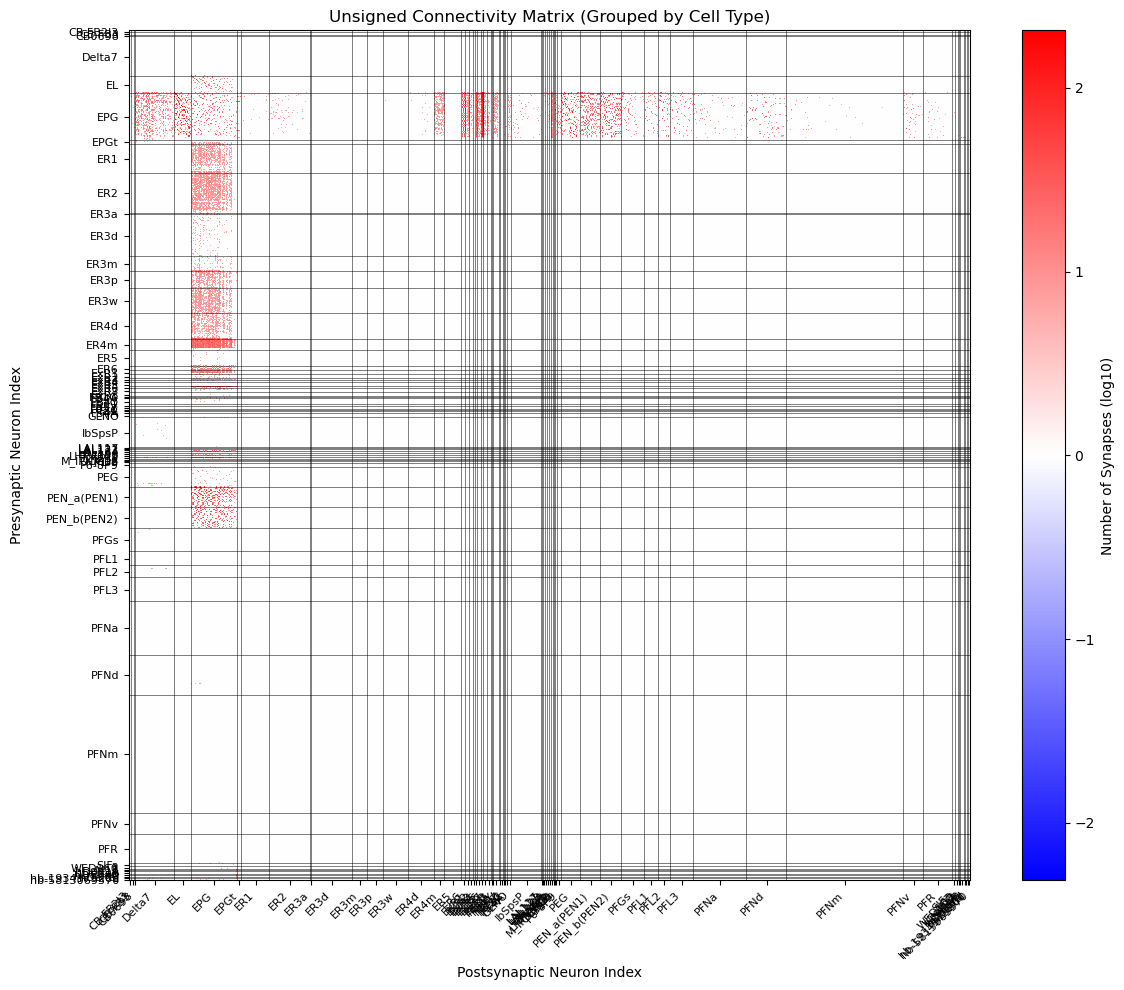

In [7]:
# Create the unsigned connectivity matrix by taking absolute values
C_unsigned_grouped = np.abs(C_signed_grouped)

# Visualize the unsigned grouped connectivity matrix
plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(C_unsigned_grouped) + 1), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(C_unsigned_grouped) + 1)), 
           vmax=np.max(np.log10(np.abs(C_unsigned_grouped) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Unsigned Connectivity Matrix (Grouped by Cell Type)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add cell type group boundaries and labels
group_boundaries = []
tick_positions = []
tick_labels = []
current_pos = 0
for cell_type in unique_cell_types:
    group_size = len(cell_type_indices[cell_type])
    group_boundaries.append(current_pos + group_size)

    # Add group label at the center of each group
    center_pos = current_pos + group_size / 2
    tick_positions.append(center_pos)
    tick_labels.append(cell_type)

    # Set x and y ticks with cell type labels
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=8)
    plt.yticks(tick_positions, tick_labels, fontsize=8)
    current_pos += group_size

# Add vertical and horizontal lines to separate groups
for boundary in group_boundaries[:-1]:  # Exclude the last boundary
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

In [8]:
variables_to_keep = ['ctoi_grouped', 'noi_grouped', 'C_signed_grouped', 'C_unsigned_grouped', 'new_order', 'unique_cell_types', 'cell_type_counts']
print("Variables to keep for further analysis:")
for var in variables_to_keep:
    if var in globals():
        var_obj = globals()[var]
        var_type = type(var_obj).__name__
        
        if hasattr(var_obj, 'shape'):
            structure = f"shape: {var_obj.shape}"
        elif hasattr(var_obj, '__len__'):
            structure = f"length: {len(var_obj)}"
        else:
            structure = "scalar"
            
        print(f"\t{var}: {var_type}, {structure}")
    else:
        print(f"\t{var}: NOT FOUND")

Variables to keep for further analysis:
	ctoi_grouped: list, length: 855
	noi_grouped: list, length: 855
	C_signed_grouped: ndarray, shape: (855, 855)
	C_unsigned_grouped: ndarray, shape: (855, 855)
	new_order: list, length: 855
	unique_cell_types: list, length: 68
	cell_type_counts: dict, length: 68


### Normalization

#### Uniform scaling

#### Information-based normalization

## System reduction

### Louvain method

In [13]:
# Set A = C_unsigned_grouped as specified
A = C_unsigned_grouped

print(f"Matrix A shape: {A.shape}")
print(f"Matrix A type: {type(A)}")
print(f"Matrix A min: {A.min()}, max: {A.max()}")
print(f"Number of non-zero entries: {np.count_nonzero(A)}")

# Convert the unsigned adjacency matrix to a NetworkX graph
G = nx.from_numpy_array(A, create_using=nx.DiGraph())

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Apply Louvain community detection
# Note: networkx uses the python-louvain package for this
try:
    communities = community.louvain_communities(G.to_undirected(), seed=42)
    print(f"Louvain detected {len(communities)} communities")
    
    # Create community assignment array
    community_labels = np.zeros(len(A), dtype=int)
    for i, comm in enumerate(communities):
        for node in comm:
            community_labels[node] = i
    
    # Print community sizes
    community_sizes = [len(comm) for comm in communities]
    print(f"Community sizes: {sorted(community_sizes, reverse=True)}")
    
    # Calculate modularity
    modularity = community.modularity(G.to_undirected(), communities)
    print(f"Modularity: {modularity:.4f}")
    
except ImportError:
    print("python-louvain not available, using alternative community detection")
    # Fallback to other community detection methods
    communities = list(community.greedy_modularity_communities(G.to_undirected()))
    print(f"Greedy modularity detected {len(communities)} communities")
    
    community_labels = np.zeros(len(A), dtype=int)
    for i, comm in enumerate(communities):
        for node in comm:
            community_labels[node] = i
    
    community_sizes = [len(comm) for comm in communities]
    print(f"Community sizes: {sorted(community_sizes, reverse=True)}")
    
    modularity = community.modularity(G.to_undirected(), communities)
    print(f"Modularity: {modularity:.4f}")

# Store results for further analysis
louvain_communities = communities
louvain_labels = community_labels
louvain_modularity = modularity

Matrix A shape: (855, 855)
Matrix A type: <class 'numpy.ndarray'>
Matrix A min: 0.0, max: 205.0
Number of non-zero entries: 8848
Graph created with 855 nodes and 8848 edges
Louvain detected 162 communities
Community sizes: [180, 174, 164, 97, 83, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Modularity: 0.2896


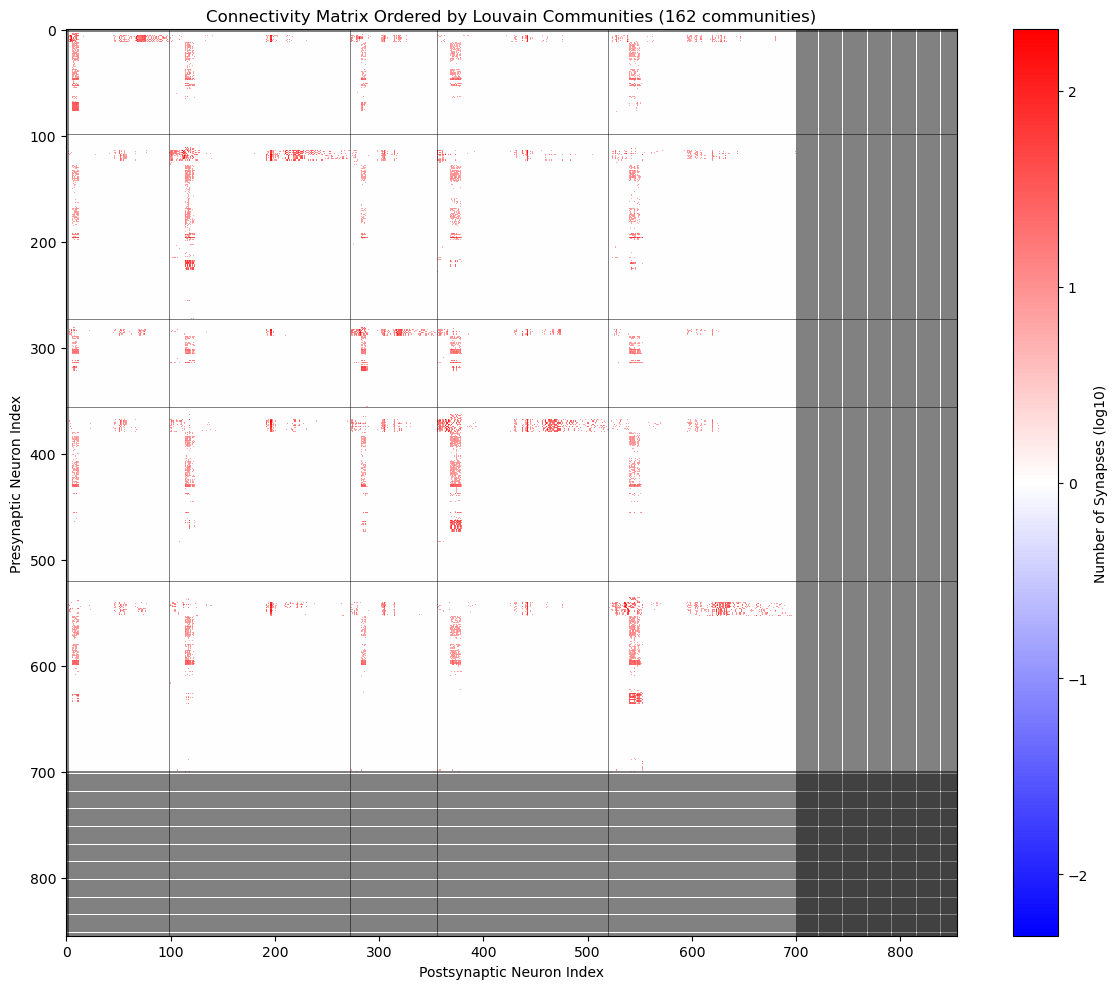


Comparison with original cell type grouping:
Original cell types: 68
Louvain communities: 162
Modularity: 0.2896

Cell type distribution across Louvain communities:
CB.FB2I3: {np.int64(0): 1, np.int64(1): 1}
CB.FB3: {np.int64(3): 1, np.int64(6): 2}
Delta7: {np.int64(2): 2, np.int64(3): 11, np.int64(4): 8, np.int64(5): 7, np.int64(6): 12}
EL: {np.int64(2): 2, np.int64(3): 3, np.int64(4): 2, np.int64(5): 5, np.int64(6): 5}
EPG: {np.int64(2): 6, np.int64(3): 10, np.int64(4): 6, np.int64(5): 12, np.int64(6): 13}
ER1: {np.int64(2): 10, np.int64(3): 5, np.int64(5): 4, np.int64(6): 10}
ER2: {np.int64(2): 7, np.int64(3): 11, np.int64(4): 3, np.int64(5): 10, np.int64(6): 10}
ER3d: {np.int64(2): 9, np.int64(3): 14, np.int64(4): 3, np.int64(5): 8, np.int64(6): 7, np.int64(7): 1}
ER3m: {np.int64(3): 10, np.int64(5): 5}
ER3p: {np.int64(2): 3, np.int64(3): 4, np.int64(4): 1, np.int64(5): 4, np.int64(6): 5}
ER3w: {np.int64(2): 2, np.int64(3): 6, np.int64(4): 1, np.int64(5): 9, np.int64(6): 7}
ER4d: 

In [20]:
# Visualize the connectivity matrix reordered by Louvain communities
# Create new ordering based on Louvain communities
louvain_order = []
for i, comm in enumerate(louvain_communities):
    louvain_order.extend(sorted(comm))

# Reorder the matrix by Louvain communities
A_louvain_ordered = A[np.ix_(louvain_order, louvain_order)]

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(A_louvain_ordered + 1), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(A_louvain_ordered + 1)),
           vmax=np.max(np.log10(A_louvain_ordered + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title(f'Connectivity Matrix Ordered by Louvain Communities ({len(louvain_communities)} communities)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add community boundaries
community_boundaries = []
current_pos = 0
for i, comm in enumerate(louvain_communities):
    community_size = len(comm)
    community_boundaries.append(current_pos + community_size)
    current_pos += community_size

# Add lines to separate communities
for boundary in community_boundaries[:-1]:
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# Compare Louvain communities with original cell type grouping
print("\nComparison with original cell type grouping:")
print(f"Original cell types: {len(unique_cell_types)}")
print(f"Louvain communities: {len(louvain_communities)}")
print(f"Modularity: {louvain_modularity:.4f}")

# Create a mapping to see how cell types are distributed across Louvain communities
cell_type_to_louvain = {}
for i, cell_type in enumerate(ctoi_grouped):
    louvain_comm = louvain_labels[i]
    if cell_type not in cell_type_to_louvain:
        cell_type_to_louvain[cell_type] = {}
    if louvain_comm not in cell_type_to_louvain[cell_type]:
        cell_type_to_louvain[cell_type][louvain_comm] = 0
    cell_type_to_louvain[cell_type][louvain_comm] += 1

# Show how cell types are split across communities
print("\nCell type distribution across Louvain communities:")
for cell_type in sorted(cell_type_to_louvain.keys()):
    comm_dist = cell_type_to_louvain[cell_type]
    if len(comm_dist) > 1:  # Only show cell types split across multiple communities
        print(f"{cell_type}: {dict(sorted(comm_dist.items()))}")

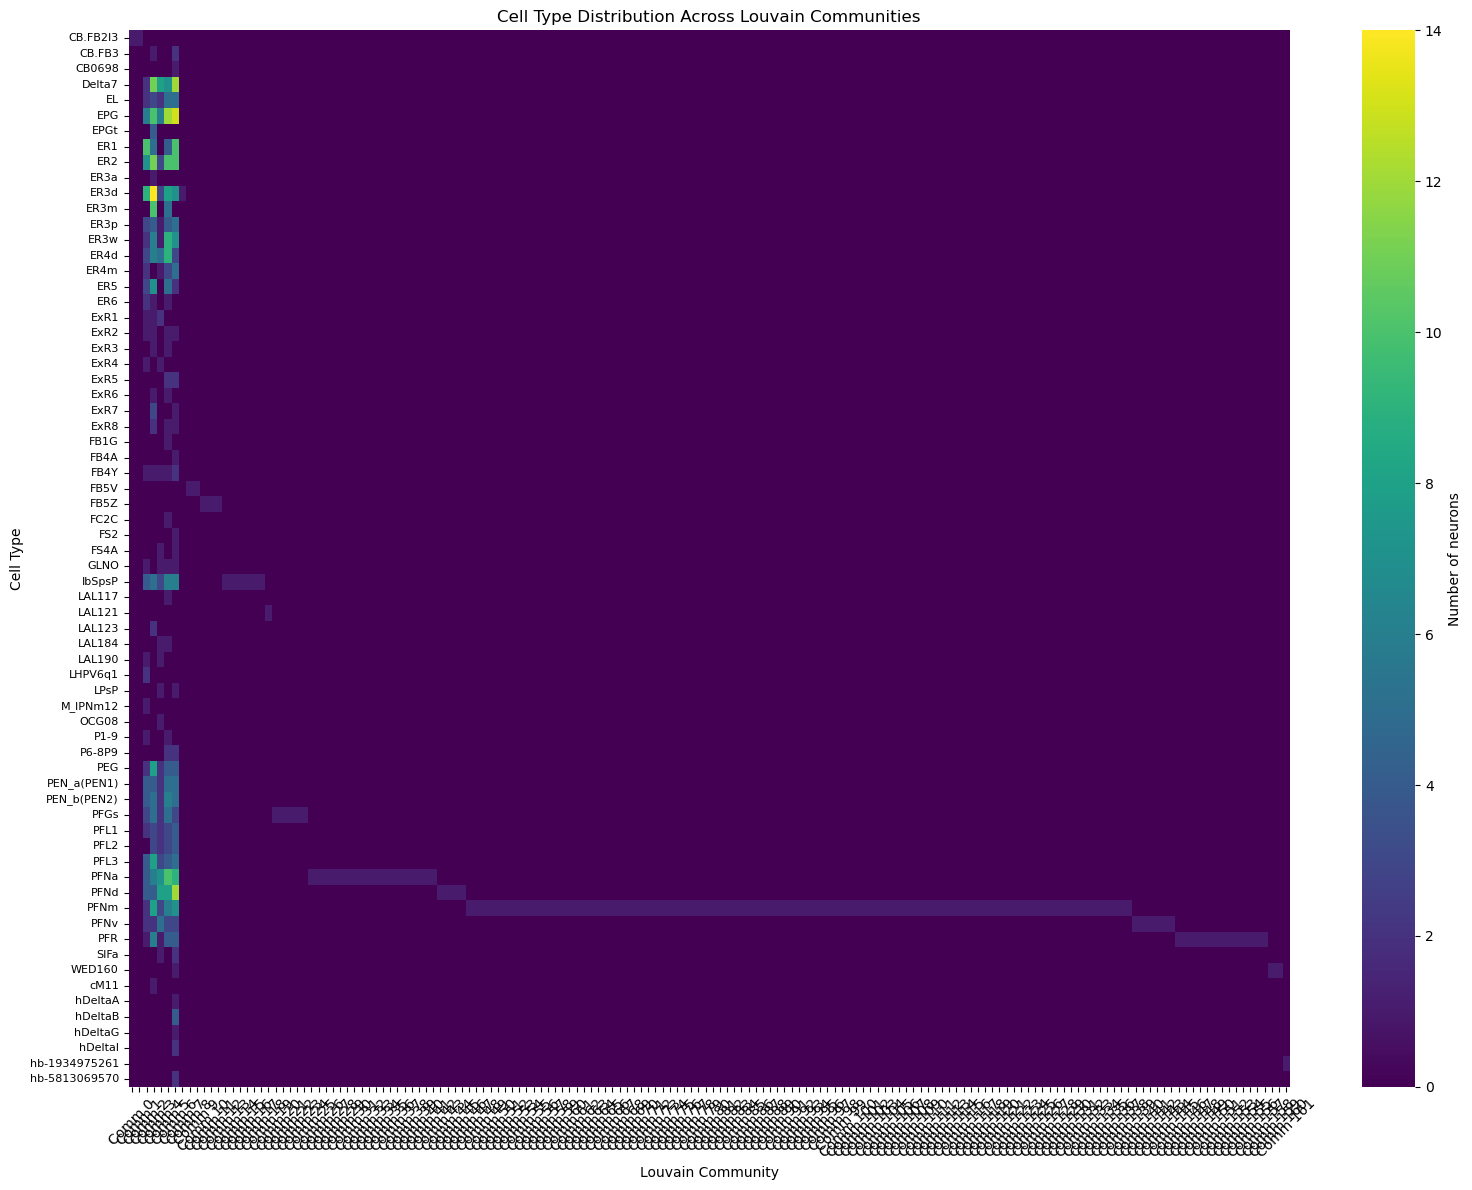

Distribution matrix shape: (68, 162)
Non-zero entries in distribution matrix: 342
Cell types split across multiple communities: 48/68
Average community purity: 0.972
Community purity range: 0.072 - 1.000


In [21]:
# Create a 2D heatmap of cell type distribution across Louvain communities
import seaborn as sns

# Create a matrix: rows = cell types, columns = Louvain communities
n_cell_types = len(unique_cell_types)
n_communities = len(louvain_communities)

# Initialize the distribution matrix
distribution_matrix = np.zeros((n_cell_types, n_communities))

# Fill the matrix
for i, cell_type in enumerate(ctoi_grouped):
    louvain_comm = louvain_labels[i]
    cell_type_idx = unique_cell_types.index(cell_type)
    distribution_matrix[cell_type_idx, louvain_comm] += 1

# Create the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(distribution_matrix, 
            xticklabels=[f'Comm {i}' for i in range(n_communities)],
            yticklabels=unique_cell_types,
            cmap='viridis',
            annot=False,
            fmt='g',
            cbar_kws={'label': 'Number of neurons'})

plt.title('Cell Type Distribution Across Louvain Communities')
plt.xlabel('Louvain Community')
plt.ylabel('Cell Type')
plt.xticks(rotation=45)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# Show statistics about the distribution
print(f"Distribution matrix shape: {distribution_matrix.shape}")
print(f"Non-zero entries in distribution matrix: {np.count_nonzero(distribution_matrix)}")

# Calculate how many cell types are split across multiple communities
split_cell_types = 0
for i in range(n_cell_types):
    if np.count_nonzero(distribution_matrix[i, :]) > 1:
        split_cell_types += 1

print(f"Cell types split across multiple communities: {split_cell_types}/{n_cell_types}")

# Calculate community purity (max cell type fraction in each community)
community_purity = []
for j in range(n_communities):
    if distribution_matrix[:, j].sum() > 0:
        purity = distribution_matrix[:, j].max() / distribution_matrix[:, j].sum()
        community_purity.append(purity)

print(f"Average community purity: {np.mean(community_purity):.3f}")
print(f"Community purity range: {np.min(community_purity):.3f} - {np.max(community_purity):.3f}")

### Leiden method

In [24]:
# Implement Leiden algorithm for community detection
# Convert NetworkX graph to igraph for Leiden algorithm
# Create adjacency list
edges = list(G.edges(data=True))
edge_list = [(u, v) for u, v, d in edges]
weights = [d['weight'] for u, v, d in edges]

# Create igraph
g_ig = ig.Graph(directed=False)
g_ig.add_vertices(G.number_of_nodes())
g_ig.add_edges(edge_list)
g_ig.es['weight'] = weights

# Apply Leiden algorithm
partition = leidenalg.find_partition(g_ig, leidenalg.ModularityVertexPartition, 
                                    weights='weight', seed=42)

# Extract community assignments
leiden_communities = [list(community) for community in partition]
leiden_labels = np.zeros(len(A), dtype=int)

for i, comm in enumerate(leiden_communities):
    for node in comm:
        leiden_labels[node] = i

leiden_modularity = partition.modularity

print(f"Leiden detected {len(leiden_communities)} communities")
leiden_community_sizes = [len(comm) for comm in leiden_communities]
print(f"Community sizes: {sorted(leiden_community_sizes, reverse=True)}")
print(f"Modularity: {leiden_modularity:.4f}")

Leiden detected 164 communities
Community sizes: [166, 126, 100, 94, 79, 78, 55, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Modularity: 0.1933


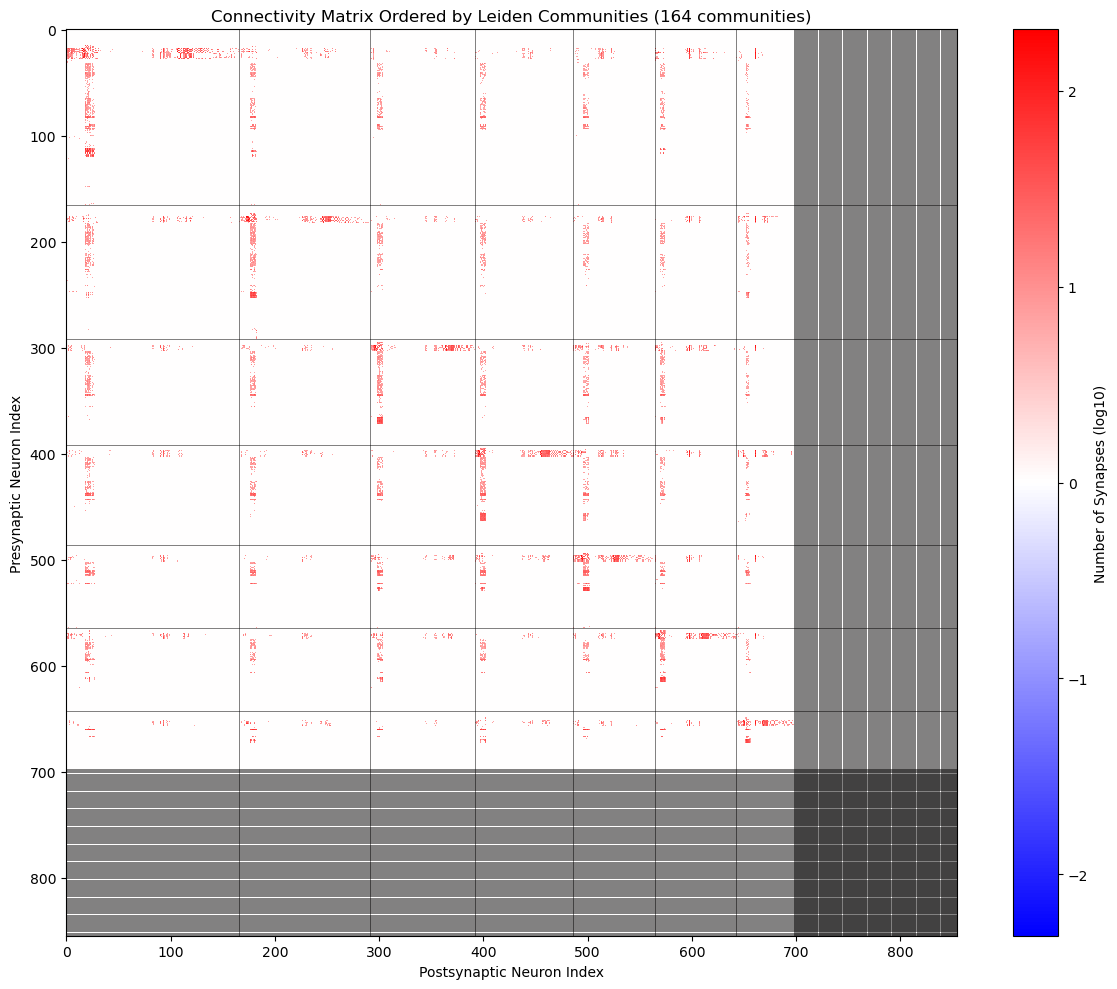


Comparison with original cell type grouping:
Original cell types: 68
Leiden communities: 164
Modularity: 0.1933


In [27]:
# Visualize Leiden communities (if available)
# Visualize the connectivity matrix reordered by Leiden communities
leiden_order = []
for i, comm in enumerate(leiden_communities):
    leiden_order.extend(sorted(comm))

# Reorder the matrix by Leiden communities
A_leiden_ordered = A[np.ix_(leiden_order, leiden_order)]

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(A_leiden_ordered + 1), 
            cmap='bwr', aspect='auto',
            vmin=-np.max(np.log10(A_leiden_ordered + 1)),
            vmax=np.max(np.log10(A_leiden_ordered + 1)),
            interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title(f'Connectivity Matrix Ordered by Leiden Communities ({len(leiden_communities)} communities)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add community boundaries
leiden_boundaries = []
current_pos = 0
for i, comm in enumerate(leiden_communities):
    community_size = len(comm)
    leiden_boundaries.append(current_pos + community_size)
    current_pos += community_size

# Add lines to separate communities
for boundary in leiden_boundaries[:-1]:
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# Compare Leiden communities with original cell type grouping
print("\nComparison with original cell type grouping:")
print(f"Original cell types: {len(unique_cell_types)}")
print(f"Leiden communities: {len(leiden_communities)}")
print(f"Modularity: {leiden_modularity:.4f}")

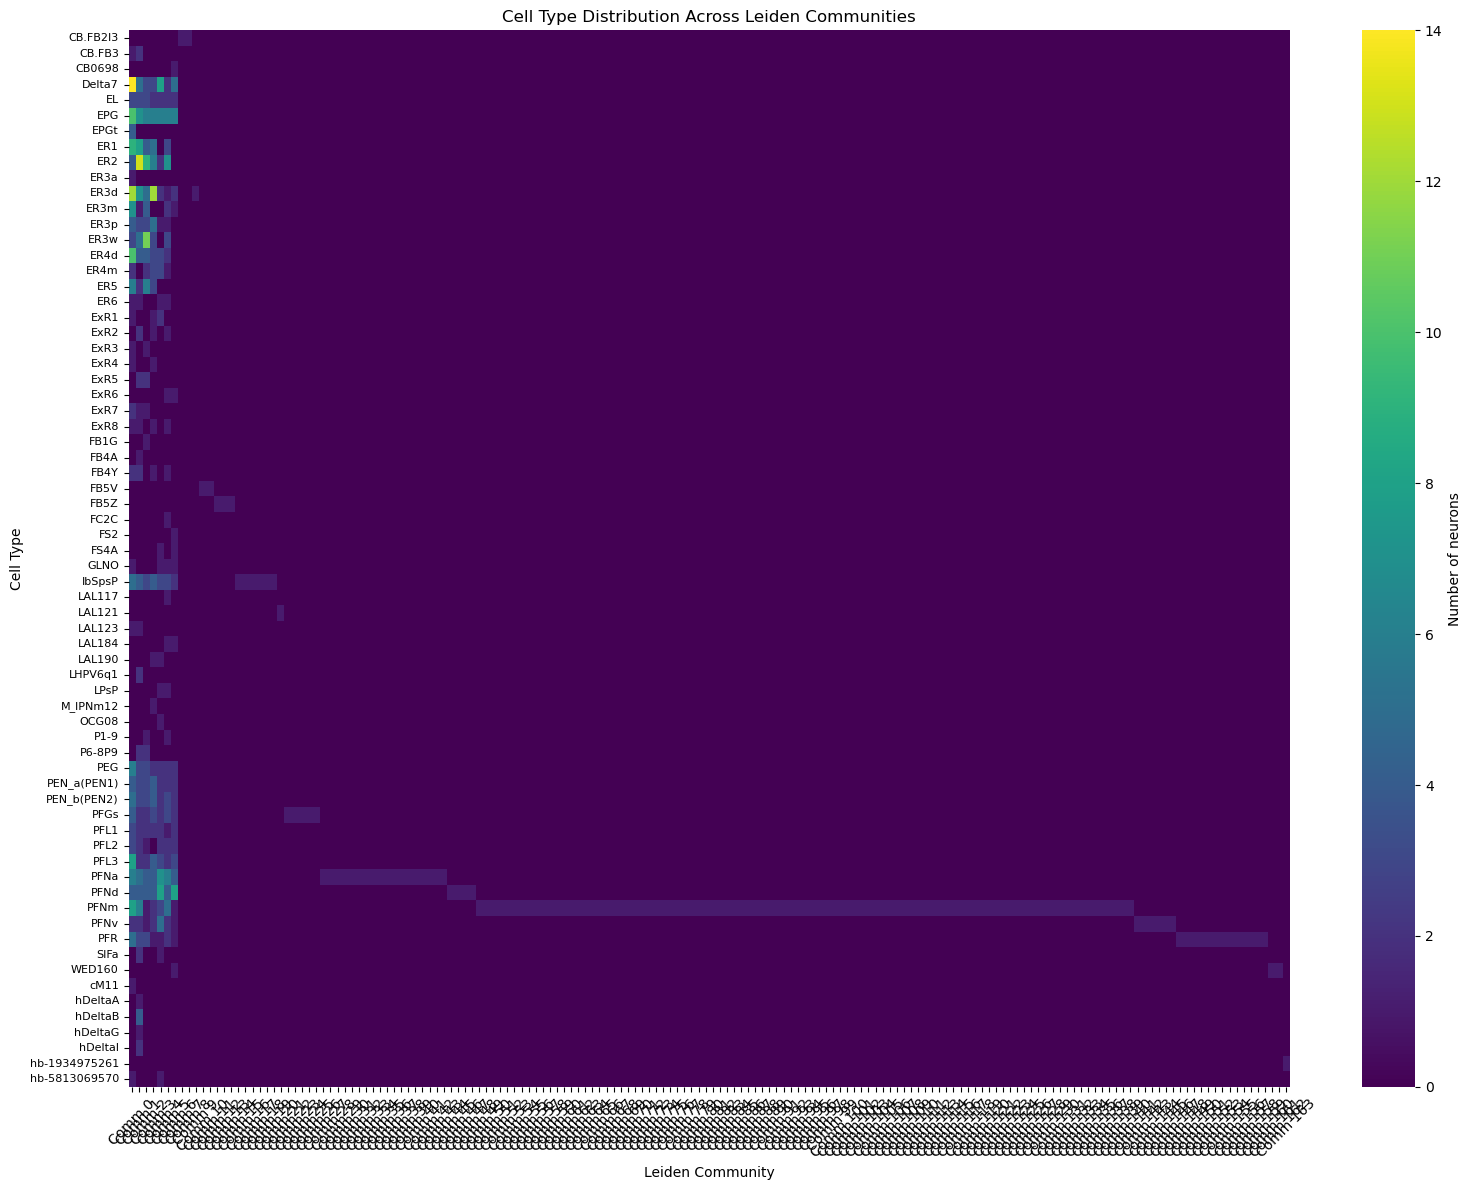

Leiden distribution matrix shape: (68, 164)
Non-zero entries in distribution matrix: 387
Cell types split across multiple communities: 50/68
Average community purity: 0.962
Community purity range: 0.084 - 1.000


In [26]:
# Create 2D heatmap for Leiden method (if available)
# Create a matrix: rows = cell types, columns = Leiden communities
n_leiden_communities = len(leiden_communities)

# Initialize the distribution matrix
leiden_distribution_matrix = np.zeros((n_cell_types, n_leiden_communities))

# Fill the matrix
for i, cell_type in enumerate(ctoi_grouped):
    leiden_comm = leiden_labels[i]
    cell_type_idx = unique_cell_types.index(cell_type)
    leiden_distribution_matrix[cell_type_idx, leiden_comm] += 1

# Create the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(leiden_distribution_matrix, 
            xticklabels=[f'Comm {i}' for i in range(n_leiden_communities)],
            yticklabels=unique_cell_types,
            cmap='viridis',
            annot=False,
            fmt='g',
            cbar_kws={'label': 'Number of neurons'})

plt.title('Cell Type Distribution Across Leiden Communities')
plt.xlabel('Leiden Community')
plt.ylabel('Cell Type')
plt.xticks(rotation=45)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# Show statistics about the distribution
print(f"Leiden distribution matrix shape: {leiden_distribution_matrix.shape}")
print(f"Non-zero entries in distribution matrix: {np.count_nonzero(leiden_distribution_matrix)}")

# Calculate how many cell types are split across multiple communities
leiden_split_cell_types = 0
for i in range(n_cell_types):
    if np.count_nonzero(leiden_distribution_matrix[i, :]) > 1:
        leiden_split_cell_types += 1

print(f"Cell types split across multiple communities: {leiden_split_cell_types}/{n_cell_types}")

# Calculate community purity
leiden_community_purity = []
for j in range(n_leiden_communities):
    if leiden_distribution_matrix[:, j].sum() > 0:
        purity = leiden_distribution_matrix[:, j].max() / leiden_distribution_matrix[:, j].sum()
        leiden_community_purity.append(purity)

print(f"Average community purity: {np.mean(leiden_community_purity):.3f}")
print(f"Community purity range: {np.min(leiden_community_purity):.3f} - {np.max(leiden_community_purity):.3f}")

## System identification

## Role discovery

### Computational library

### Canonical labeling

## System synthesis

## Graph Laplacian